In [47]:
from utils.dataset import Dataset
from model import Net
# from utils.utils import calculate_accuracy

from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
import snntorch.functional as SF

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
batch_size = 128 # batch size for dataloader 

Device:  cpu


In [49]:
data_path = '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/'
print("Loading dataset from: ", data_path)
dataset = Dataset()
records,annotations = dataset.load_dataset(data_path)
X = []
y = []
X, y = dataset.preprocess(records, annotations)

if X or y is not None:
    print("Signals loaded successfully..................")
    # print(len(X))
    

Loading dataset from:  /home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/
Loading dataset from:  /home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/
Signals loaded successfully..................


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                        random_state=104,
                        train_size=0.8, shuffle=True)

X_train = torch.tensor(X_train , dtype=torch.float32)
X_test = torch.tensor(X_test , dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


training_set = torch.utils.data.TensorDataset(X_train, y_train)
test_set = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(training_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

print("Dataset loaded successfully..................")

Dataset loaded successfully..................


In [51]:
# Define network parameters
num_inputs = 360
num_hidden = 1000
num_outputs = 5
num_steps = 1
beta = 0.95

In [52]:
LIF_Model = Net(num_hidden, num_inputs, num_outputs, num_steps, beta).to(device)
print(LIF_Model)
print("Model loaded successfully..................")

Net(
  (fc1): Linear(in_features=360, out_features=1000, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1000, out_features=5, bias=True)
  (lif2): Leaky()
)
Model loaded successfully..................


In [53]:
# loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LIF_Model.parameters(), lr=0.0005 , betas=(0.9, 0.999))

In [54]:
num_epochs = 10
train_acc = []
test_acc = []
loss_hist = []
test_loss_hist = []
counter = 0
dtype = torch.float 

In [55]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = LIF_Model(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

# def train_printer(epoch, data,targets,test_data,test_targets, iter_counter, loss_hist, test_loss_hist):
def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_count}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [28]:
def cross_entropy_loss(input, target):
  """Computes the cross-entropy loss between two tensors.

  Args:
    input: A tensor of predictions, with shape (batch_size, num_classes).
    target: A tensor of targets, with shape (batch_size).

  Returns:
    A tensor of losses, with shape (batch_size).
  """
  input = input.view(128, 5)
  # Cast the target tensor to type float32.
  target = target.float()

  # Compute the log softmax of the input tensor.
  log_softmax = torch.nn.functional.log_softmax(input, dim=1)

  # Compute the cross-entropy loss.
  loss = -(target * log_softmax).sum(dim=1)

  return loss




In [56]:
import snntorch.functional as SF

loss_fn = SF.ce_max_membrane_loss()

In [57]:
for epoch in range(num_epochs):
    iter_count = 0
    train_batch = iter(train_loader)

    #Minibatch training 
    for data , targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # data = data.to(torch.float32)
        # targets = targets.to(torch.long)

        LIF_Model.train()
        spk_rec , mem_rec = LIF_Model(data)
        # y_predicted = torch.argmax(spk_rec.sum(0), dim=1)
        # mem_rec = mem_rec.sum(0)
        # print(mem_rec.shape) 128*5

        # print(spk_rec.shape) 1*128*5
        # print(spk_rec.sum(0).shape) 128*5
        # print(y_predicted.shape) 128

        loss_val = torch.zeros((1) , dtype=torch.float32).to(device)
        
        # print(targets.dtype, spk_rec.dtype, mem_rec.dtype, loss_val.dtype)

        loss_val = loss_val + loss_fn(mem_rec, targets.long())
        # print(loss_val)
        
        '''
        for step in range(num_steps):
            loss_val += loss_fn(mem_rec, targets.long())
        '''
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        loss_hist.append(loss_val.item())


        with torch.no_grad():
            LIF_Model.eval()
            test_data , test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            test_spk , test_mem = LIF_Model(test_data)

            test_loss_val = torch.zeros(1).to(device)
            # for step in range(num_steps):
            #     test_loss_val += loss_fn(test_mem[step], test_targets.long())
            test_loss_val += loss_fn(test_mem, test_targets.long())
            test_loss_hist.append(test_loss_val.item())
            
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_count +=1
        



Epoch 0, Iteration 0
Train Set Loss: 1.58
Test Set Loss: 1.53
Train set accuracy for a single minibatch: 78.91%
Test set accuracy for a single minibatch: 71.09%


Epoch 0, Iteration 50
Train Set Loss: 0.42
Test Set Loss: 0.39
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 100
Train Set Loss: 0.10
Test Set Loss: 0.15
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 96.88%


Epoch 0, Iteration 150
Train Set Loss: 0.10
Test Set Loss: 0.15
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 96.88%


Epoch 0, Iteration 200
Train Set Loss: 0.11
Test Set Loss: 0.14
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 96.88%


Epoch 0, Iteration 250
Train Set Loss: 0.13
Test Set Loss: 0.14
Train set accuracy for a single minibatch: 96.09%
Test set accuracy for a single minibatch: 97.66%


Epoch 0, Iter

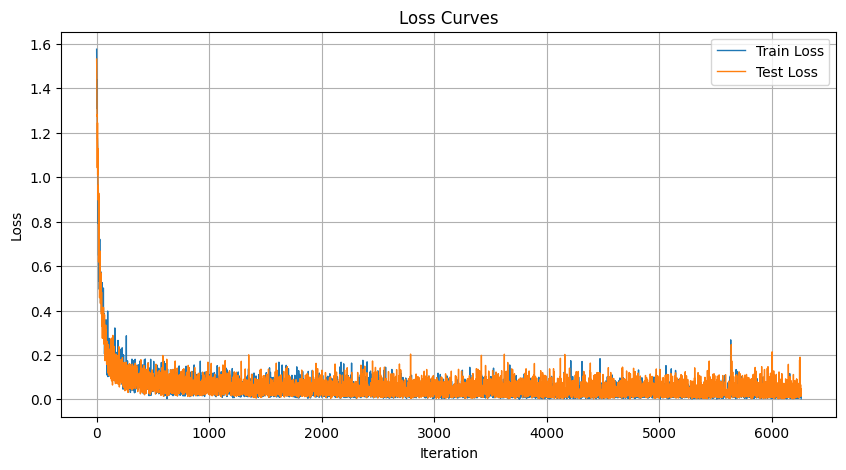

In [58]:
# Plot Loss

import matplotlib.pyplot as plt

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

%matplotlib inline



In [59]:
total = 0
correct = 0 

with torch.no_grad():
    LIF_Model.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = LIF_Model(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

In [60]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 19562/20003
Test Set Accuracy: 97.80%


In [61]:
#save the model 
torch.save(LIF_Model.state_dict(), 'model/model1.pth')